# Tensorflow demo

This demo is built on a subset of the information from the New York City Taxi & Limousine Commission

In this demo we will use Tensorflow machine learning library to train a model on Taxi usage and later use this model to predict the demand on different parts of the New York City

# Import and exploratory analysis

In [2]:
import pandas as pd
import numpy as np
import shutil
import datetime
import tensorflow as tf
%matplotlib inline

In [3]:
data = pd.read_csv("green_tripdata_2017-01.csv")
data['lpep_pickup_datetime'] = pd.to_datetime(data.lpep_pickup_datetime, format='%Y-%m-%dT%H:%M:%S')

data.total_amount = data.total_amount.astype('float32')
data['weekday'] = data.lpep_pickup_datetime.dt.weekday
data['daynumber'] = data.lpep_pickup_datetime.dt.day
data['hour'] = data.lpep_pickup_datetime.dt.hour

data.weekday = data.weekday.astype('float32')
data.daynumber = data.daynumber.astype('float32')
data.hour = data.hour.astype('float32')

## Data preview

In [4]:
data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,weekday,daynumber,hour
0,2,2017-01-01 00:01:15,2017-01-01 00:11:05,N,1,42,166,1,1.71,9.0,...,0.00,0.0,NaN,0.3,9.80,2,1,6.0,1.0,0.0
1,2,2017-01-01 00:03:34,2017-01-01 00:09:00,N,1,75,74,1,1.44,6.5,...,0.00,0.0,NaN,0.3,7.80,2,1,6.0,1.0,0.0
2,2,2017-01-01 00:04:02,2017-01-01 00:12:55,N,1,82,70,5,3.45,12.0,...,2.66,0.0,NaN,0.3,15.96,1,1,6.0,1.0,0.0
3,2,2017-01-01 00:01:40,2017-01-01 00:14:23,N,1,255,232,1,2.11,10.5,...,0.00,0.0,NaN,0.3,11.80,2,1,6.0,1.0,0.0
4,2,2017-01-01 00:00:51,2017-01-01 00:18:55,N,1,166,239,1,2.76,11.5,...,0.00,0.0,NaN,0.3,12.80,2,1,6.0,1.0,0.0


## Passenger counts by weekday

In [6]:
data.groupby(['weekday'])['passenger_count'].agg('sum')

weekday
0.0    199062
1.0    216055
2.0    173909
3.0    187510
4.0    218382
5.0    221256
6.0    248442
Name: passenger_count, dtype: int64

## Passenger counts by Pick up location, weekday and hour

In [8]:
agr = data.groupby(['PULocationID','weekday','hour'])['passenger_count'].agg('count').to_frame().reset_index()
agr.head()

,PULocationID,weekday,hour,passenger_count
0,1,1.0,15.0,1
1,1,1.0,16.0,1
2,1,2.0,4.0,1
3,1,2.0,18.0,1
4,1,4.0,8.0,1


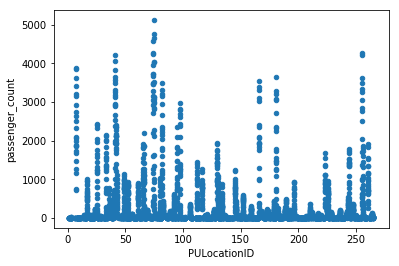

In [10]:
agr = data.groupby(['PULocationID','hour'])['passenger_count'].agg('count')
agr=agr.to_frame().reset_index()
agr.plot(kind='scatter', x='PULocationID', y='passenger_count')

## Total amount by weekday

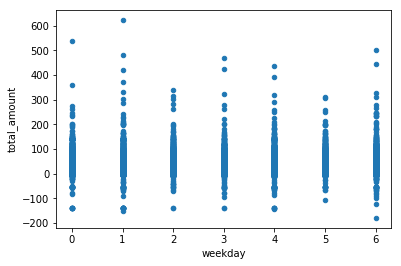

In [9]:
data.plot(kind='scatter', x='weekday', y='total_amount')

# Tensorflow linear regression

Shuffle data and extract the predictor feature (PULocationID, weekday, daynumber, hour) and target feature (total amount)

In [11]:
import tensorflow as tf
shuffled = data.sample(frac=1, random_state=13)

In [12]:
predictors = shuffled.iloc[:,[5,19,20,21]]
predictors[:5]

,PULocationID,weekday,daynumber,hour
668898,41,4.0,20.0,19.0
432002,80,4.0,13.0,22.0
803588,152,1.0,24.0,16.0
833963,255,2.0,25.0,14.0
1029208,52,0.0,30.0,18.0


In [13]:
targets = shuffled.iloc[:,16]
targets[:5]

668898      7.300000
432002     18.959999
803588      8.800000
833963     25.700001
1029208    10.380000
Name: total_amount, dtype: float32

In [14]:
trainsize = int(len(shuffled['total_amount']) * 0.8)
avg = np.mean(shuffled['total_amount'][:trainsize])
rmse = np.sqrt(np.mean((targets[trainsize:] - avg)**2))
print 'Just using average={0} has RMSE of {1}'.format(avg, rmse)

Just using average=13.6359624863 has RMSE of 10.1570358276


# Linear regression with tf.contrib.learn

Train the model Using 2 datasets: train with 80% of data. Test with 20% of data. Linear regression model

In [15]:
trainsize = int(len(shuffled['total_amount']) * 0.8)
testsize = len(shuffled['total_amount']) - trainsize
npredictors = len(predictors.columns)
noutputs = 1
tf.logging.set_verbosity(tf.logging.WARN) # change to INFO to get output every 100 steps ...
shutil.rmtree('./trained_model_linear', ignore_errors=True) # so that we don't load weights from previous runs
estimator = tf.contrib.learn.LinearRegressor(model_dir='./trained_model_linear',
                                             feature_columns=tf.contrib.learn.infer_real_valued_columns_from_input(predictors.values))

print "starting to train ... this will take a while ... use verbosity=INFO to get more verbose output"
def input_fn(features, targets):
  return tf.constant(features.values), tf.constant(targets.values.reshape(len(targets), noutputs))
estimator.fit(input_fn=lambda: input_fn(predictors[:trainsize], targets[:trainsize]), steps=10000)

pred = np.multiply(list(estimator.predict(predictors[trainsize:].values)), 1 )
rmse = np.sqrt(np.mean(np.power((targets[trainsize:].values - pred), 2)))
print 'LinearRegression has RMSE of {0}'.format(rmse)


starting to train ... this will take a while ... use verbosity=INFO to get more verbose output
Instructions for updating:
Please switch to tf.train.get_global_step
Instructions for updating:
Please switch to predict_scores, or set `outputs` argument.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
LinearRegression has RMSE of 10.134563446


# Predict

Predict for a given day and pickup location the total amount

In [125]:
input = pd.DataFrame.from_dict(data=
                      {'PULocationId': [50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50],
                    'weekday':   [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    'daynumber': [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5],
                    'hour': [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]}
)

In [126]:
# read trained model from ./trained_model
estimator = tf.contrib.learn.LinearRegressor(model_dir='./trained_model_linear',
                                          feature_columns=tf.contrib.learn.infer_real_valued_columns_from_input(input.values))

pred = np.multiply(list(estimator.predict(input.values)), 1 )
print pred

[ 13.77240849  13.78306389  13.79371929  13.80437469  13.8150301
  13.8256855   13.8363409   13.84699631  13.85765171  13.86830711
  13.87896347  13.88961887  13.90027428  13.91092968  13.92158508
  13.93224049  13.94289589  13.95355129  13.9642067   13.9748621
  13.9855175   13.9961729   14.00682831  14.01748371]



According to the prediction, the best hours are from 21 to midnight